In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz


In [3]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz


tar: spark-3.1.2-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [9]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Analyse des parcours universitaires et de la réussite en licence") \
    .getOrCreate()

# Chargement des données
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .load("/content/fr-esr-parcours-et-reussite-des-bacheliers-en-licence.csv")

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Nettoyage des données

In [11]:
cleaned_data = df.dropna()

In [12]:
#Créez une session Spark qui vous permettra de manipuler les données avec PySpark :
spark = SparkSession.builder \
    .appName("Analyse des parcours et de la réussite des étudiants en licence") \
    .getOrCreate()

In [13]:
#Vérifiez que Spark est correctement installé et configuré en exécutant une commande simple pour afficher la version de Spark :
spark.version


'3.5.1'

In [14]:
df.show(5)


+-------------+--------------------+----------+--------------------+------------------+----------------------+---------+--------------------+----------+--------------------+----+--------+-----------+--------------------+---------------+------------------------------+------------------+------------------+-------------------+---------------------+-------------------------+--------------------------+--------------------+----------------+-------------------------------+--------------+--------------+----------------+
|gd_discipline|   gd_discipline_lib|discipline|      discipline_lib|sect_disciplinaire|sect_disciplinaire_lib|serie_bac|       serie_bac_lib|age_au_bac|      age_au_bac_lib|sexe|sexe_lib|mention_bac|     mention_bac_lib|cohorte_passage|effectif_neobacheliers_passage|passage_en_l2_1_an|redoublement_en_l1|passage_en_l2_2_ans|passage_en_l2_1_2_ans|reorientation_en_dut_1_an|reorientation_en_dut_2_ans|reorientation_en_dut|cohorte_reussite|effectif_neobacheliers_reussite|reussite_3_a

**Analyse des données et génération de graphiques**

Nous allons maintenant utiliser PySpark pour effectuer certaines analyses et Matplotlib pour les visualisations.

Importer les bibliothèques nécessaires


In [15]:
# importer Matplotlib
import matplotlib.pyplot as plt


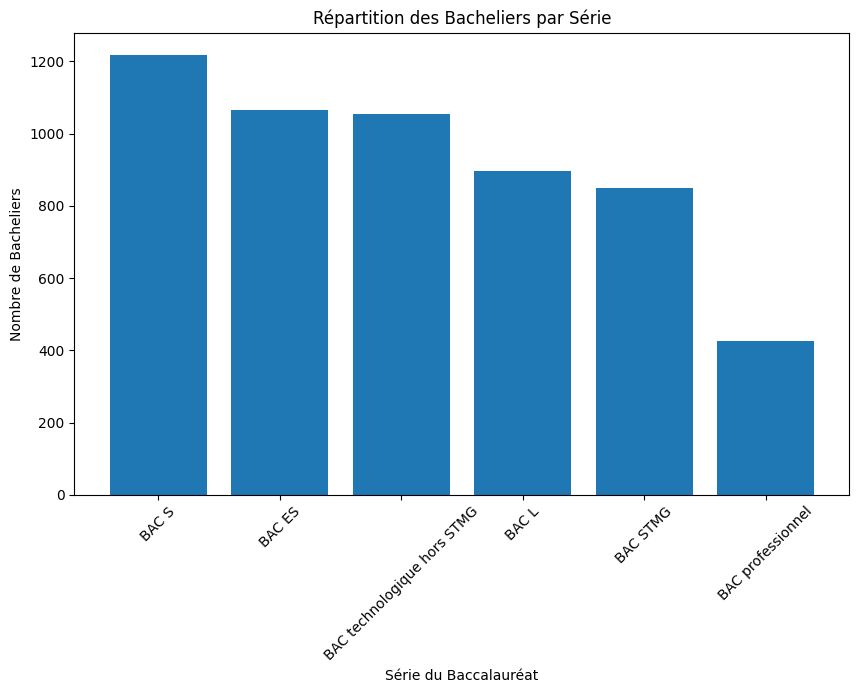

In [20]:
#Répartition des bacheliers par série


# Compter le nombre de bacheliers par série
series_distribution = df.groupBy("serie_bac_lib").count().orderBy("count", ascending=False).toPandas()

# Visualiser la répartition avec un bar chart
plt.figure(figsize=(10, 6))
plt.bar(series_distribution['serie_bac_lib'], series_distribution['count'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Nombre de Bacheliers')
plt.title('Répartition des Bacheliers par Série')
plt.xticks(rotation=45)
plt.show()

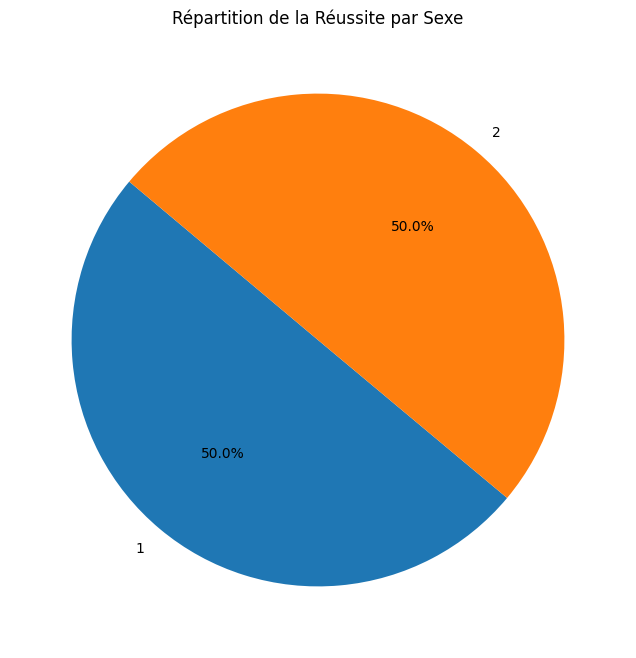

In [32]:
#Analyse de la réussite selon le sexe



# Compter le nombre de réussites par sexe
success_distribution = df.groupBy("Sexe").count().orderBy("count", ascending=False).toPandas()

# Visualiser la répartition avec un pie chart
plt.figure(figsize=(8, 8))
plt.pie(success_distribution['count'], labels=success_distribution['Sexe'], autopct='%1.1f%%', startangle=140)
plt.title('Répartition de la Réussite par Sexe')
plt.show()

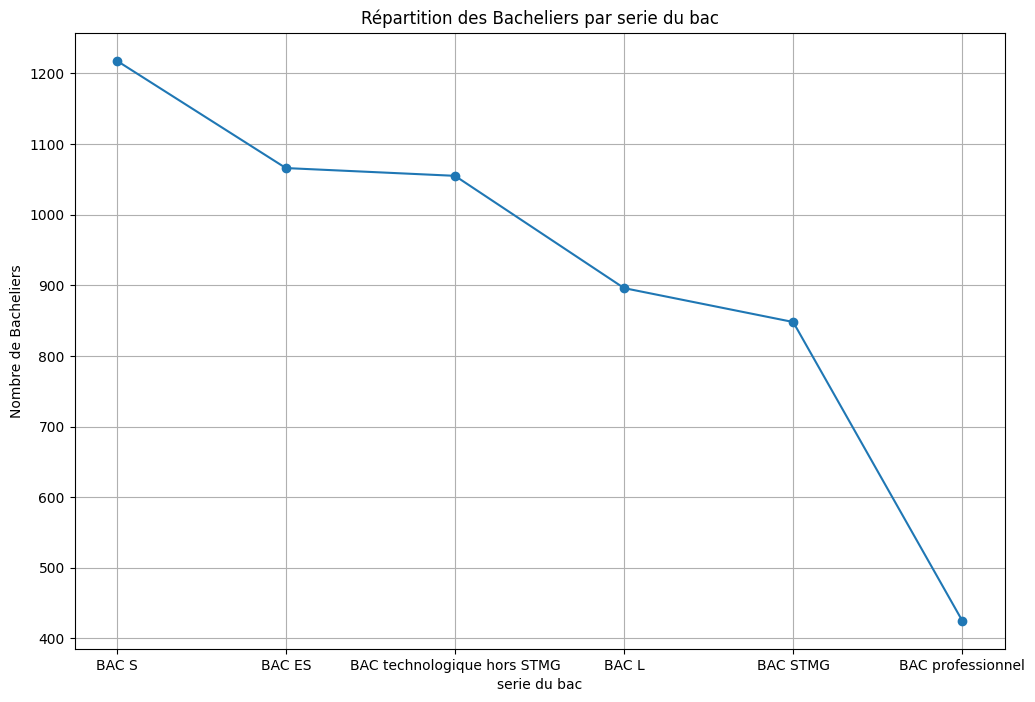

In [24]:
# Compter le nombre de bacheliers par serie de bac
academie_distribution = df.groupBy("serie_bac_lib").count().orderBy("count", ascending=False).toPandas()

# Visualiser le taux de réussite avec une courbe
plt.figure(figsize=(12, 8))
plt.plot(academie_distribution['serie_bac_lib'], academie_distribution['count'], marker='o')
plt.xlabel('serie du bac')
plt.ylabel('Nombre de Bacheliers')
plt.title('Répartition des Bacheliers par serie du bac')
plt.grid(True)
plt.show()


In [26]:

#Taux de passage_en_l2 en 1 année par série de baccalauréat

from pyspark.sql.functions import when, col, sum, count
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, col

# Ajouter une colonne indiquant si l'étudiant a réussi
df = df.withColumn("Reussite", when(col("passage_en_l2_1_an").isNotNull(), 1).otherwise(0))

# Calculer le taux de réussite par série de baccalauréat
success_rate_by_series = df.groupBy("serie_bac_lib").agg(
    (sum("Reussite") / count("Reussite")).alias("Taux_de_reussite")
).orderBy("Taux_de_reussite", ascending=False).toPandas()

# Visualiser le taux de réussite avec un bar chart
plt.figure(figsize=(12, 8))
plt.bar(success_rate_by_series['serie_bac_lib'], success_rate_by_series['Taux_de_reussite'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Taux de Réussite')
plt.title('Taux de passage en l2 dans un 1an par Série de Baccalauréat')
plt.xticks(rotation=45)
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

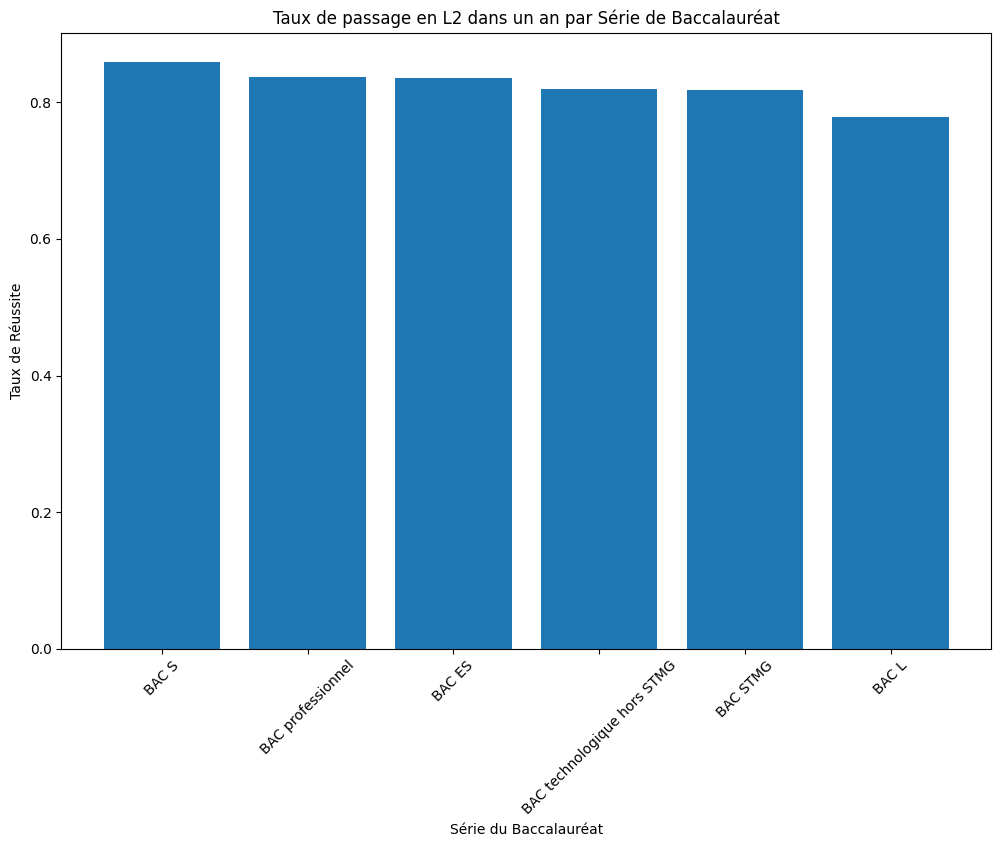

In [29]:
from pyspark.sql.functions import when, col, sum, count
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Ajouter une colonne indiquant si l'étudiant a réussi et convertir en type Integer
df = df.withColumn("Reussite", when(col("passage_en_l2_1_an").isNotNull(), 1).otherwise(0).cast(IntegerType()))

# Calculer le taux de réussite par série de baccalauréat
success_rate_by_series = df.groupBy("serie_bac_lib").agg(
    (sum("Reussite") / count("Reussite")).alias("Taux_de_reussite")
).orderBy("Taux_de_reussite", ascending=False).toPandas()

# Visualiser le taux de réussite avec un bar chart
plt.figure(figsize=(12, 8))
plt.bar(success_rate_by_series['serie_bac_lib'], success_rate_by_series['Taux_de_reussite'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Taux de Réussite')
plt.title('Taux de passage en L2 dans un an par Série de Baccalauréat')
plt.xticks(rotation=45)
plt.show()